In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. 加载数据
file_path = r'E:\Pythonworkshop\Solar_data_processing\cleaned_data_final_Yulara.csv'
data = pd.read_csv(file_path)

# 删除时间戳列
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])

# 添加前一时刻的功率数据作为新的特征
data['Prev_Power'] = data['Active_Power'].shift(1)
data['Prev_Power'] = data['Prev_Power'].fillna(0)  # 处理缺失值

# 数据集划分
X = data.drop(columns=['Active_Power'])
y = data['Active_Power']

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# 使用训练集数据进行归一化
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 仅使用训练集数据拟合scaler
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# 使用训练集的归一化参数对验证集和测试集进行归一化
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# 定义滑动窗口函数
def create_sliding_window_features(X, y, window_size, forecast_horizon, step_size=1):
    """
    创建滑动窗口特征和目标，允许不同的历史窗口和未来预测步长。
    参数:
    - X: 输入特征数据 (ndarray 或 DataFrame)
    - y: 目标数据 (ndarray 或 Series)
    - window_size: 历史窗口大小 (时间步数)
    - forecast_horizon: 未来预测步长
    - step_size: 窗口移动的步长
    返回:
    - X_windows: 滑动窗口特征 (ndarray)
    - y_windows: 滑动窗口目标 (ndarray)
    """
    X_windows = []
    y_windows = []
    for start in range(0, len(X) - window_size - forecast_horizon + 1, step_size):
        end = start + window_size
        X_windows.append(X[start:end].values if isinstance(X, pd.DataFrame) else X[start:end])
        y_windows.append(y[end:end + forecast_horizon].reshape(-1))

    return np.array(X_windows), np.array(y_windows)

# 设置滑动窗口大小和预测步长
window_size = 12  # 历史数据的时间步长
forecast_horizon = 6  # 未来预测的时间步长
output_size = forecast_horizon  # 输出大小
# 创建滑动窗口数据
X_train_multi, y_train_multi = create_sliding_window_features(X_train_scaled, y_train_scaled, window_size, forecast_horizon)
X_val_multi, y_val_multi = create_sliding_window_features(X_val_scaled, y_val_scaled, window_size, forecast_horizon)
X_test_multi, y_test_multi = create_sliding_window_features(X_test_scaled, y_test_scaled, window_size, forecast_horizon)

# 打印形状以验证
print("X_train_multi shape:", X_train_multi.shape)
print("y_train_multi shape:", y_train_multi.shape)
print("X_val_multi shape:", X_val_multi.shape)
print("y_val_multi shape:", y_val_multi.shape)
print("X_test_multi shape:", X_test_multi.shape)
print("y_test_multi shape:", y_test_multi.shape)


X_train_multi shape: (73023, 12, 11)
y_train_multi shape: (73023, 6)
X_val_multi shape: (15634, 12, 11)
y_val_multi shape: (15634, 6)
X_test_multi shape: (15635, 12, 11)
y_test_multi shape: (15635, 6)


In [3]:
def scheduler(epoch, lr):
    if epoch < 20:
        return lr  # 直接返回 lr
    else:
        return lr * tf.math.exp(-0.1).numpy()  # 计算新的学习率并转换为浮点数

# 创建 LearningRateScheduler 回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)



# 创建 EarlyStopping 回调
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 监控验证集损失
    patience=30,         # 在10个epoch后停止，如果val_loss没有改进
    verbose=1,
    restore_best_weights=True  # 恢复最佳模型的权重
)

In [4]:
# class LNNLayer(layers.Layer): 
#     def __init__(self, input_size, hidden_size):
#         super(LNNLayer, self).__init__()
#         self.hidden_size = hidden_size
#         self.W_in = self.add_weight(shape=(input_size, hidden_size), initializer='glorot_uniform', trainable=True)
#         self.W_rec = self.add_weight(shape=(hidden_size, hidden_size), initializer='glorot_uniform', trainable=True)
#         self.W_tau = self.add_weight(shape=(input_size + hidden_size, hidden_size), initializer='glorot_uniform', trainable=True)
#         self.activation = tf.nn.tanh
#         self.tau_activation = tf.nn.softplus  # 使用 softplus 激活函数确保时间常数为正

#     def call(self, inputs, state):
#         new_state = self.activation(tf.matmul(inputs, self.W_in) + tf.matmul(state, self.W_rec))
#         combined = tf.concat([inputs, state], axis=-1)
#         tau = self.tau_activation(tf.matmul(combined, self.W_tau)) + 1e-6  # 确保 tau 不为零
#         state = state + (1.0 / tau) * (new_state - state)
#         return state

# class LNNModel(tf.keras.Model):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LNNModel, self).__init__()
#         self.lnn_layer = LNNLayer(input_size, hidden_size)
#         self.fc = layers.Dense(output_size)

#     def call(self, inputs):
#         state = tf.zeros((tf.shape(inputs)[0], self.lnn_layer.hidden_size))
#         for t in range(inputs.shape[1]):
#             state = self.lnn_layer(inputs[:, t, :], state)
#         output = self.fc(state)
#         return output

# # 模型参数
# input_size = X_train_scaled.shape[1]
# hidden_size = 90
# output_size = 6

# # 构建模型
# lnn_model = LNNModel(input_size, hidden_size, output_size)

# # 编译模型（使用梯度裁剪）
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
# lnn_model.compile(optimizer=optimizer, loss='mse')

# # 训练模型
# history_lnn = lnn_model.fit(
#     X_train_multi, 
#     y_train_multi, 
#     epochs=100, 
#     batch_size=64, 
#     validation_data=(X_val_multi, y_val_multi),
#     callbacks=[lr_scheduler, early_stopping]  # 添加回调
# )

# # 测试模型
# y_pred_lnn_multi = lnn_model.predict(X_test_multi)
# y_pred_lnn = scaler_y.inverse_transform(y_pred_lnn_multi)


Epoch 1/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 2/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 3/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 4/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 5/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 6/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 7/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 8/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 9/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 10/100
1141/1141 ━━━━━━━━━━━━━━

In [5]:
from tensorflow.keras import layers, models, dropout

# 构建一个简单的 LSTM 模型
lstm_model = models.Sequential([
    layers.LSTM(90, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2]), return_sequences=False),
    layers.dropout(0.2),
    layers.Dense(output_size) 
])

# 编译模型
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# 训练模型
history_lstm = lstm_model.fit(
    X_train_multi,
    y_train_multi,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_multi, y_val_multi),
    callbacks=[lr_scheduler, early_stopping]  # 使用与 LNN 相同的回调进行对比
)

# 测试模型
y_pred_lstm_multi = lstm_model.predict(X_test_multi)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_multi)

# 打印预测结果的前 5 个样本进行检查
print("LSTM 模型预测的前 5 个样本：")
print(y_pred_lstm[:5])


Epoch 1/100


c:\Users\bo.chen18\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:203: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1102 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 2/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0327 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 3/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0292 - val_loss: 0.0542 - learning_rate: 0.0010
Epoch 4/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0277 - val_loss: 0.0590 - learning_rate: 0.0010
Epoch 5/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0267 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 6/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0268 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 7/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0243 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 8/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0238 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 9/100
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0229 - val_loss: 0.0572 - learning_rate: 0.

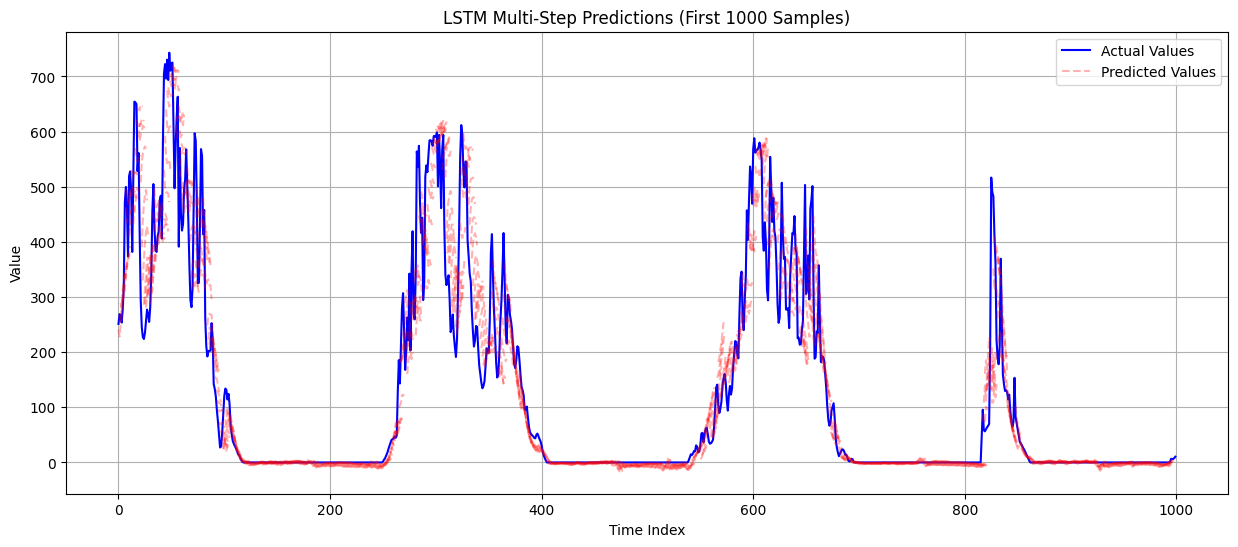

In [6]:
# 反归一化 y_test_multi 和 y_pred
y_test_multi_inverse = scaler_y.inverse_transform(y_test_multi.reshape(-1, 1)).reshape(y_test_multi.shape)

# 定义函数以便可视化多步预测结果
def plot_multi_step_predictions(y_true, y_pred, num_samples=100, model_name="Model"):
    plt.figure(figsize=(15, 6))

    # 绘制实际值
    plt.plot(range(num_samples), y_true[:num_samples, 0], label='Actual Values', color='blue')

    # 绘制每次预测的未来多个时间步的叠加效果
    for i in range(num_samples - output_size):  # output_size 是未来预测的步长
        plt.plot(range(i, i + output_size), y_pred[i, :], linestyle='--', color='red', alpha=0.3)

    plt.title(f'{model_name} Multi-Step Predictions (First {num_samples} Samples)')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.legend(['Actual Values', 'Predicted Values'])
    plt.grid(True)
    plt.show()

# 使用 LSTM 模型的反归一化预测结果进行可视化
plot_multi_step_predictions(y_test_multi_inverse, y_pred_lstm, num_samples=1000, model_name="LSTM")


Average MSE over 6 steps (y_true > 10): 5811.0094
Average RMSE over 6 steps (y_true > 10): 76.2300
Average MAE over 6 steps (y_true > 10): 49.4384
Average MAPE over 6 steps (y_true > 10): 22.7826%
Average MSE over 6 steps (y_true > 10): 7633.8913
Average RMSE over 6 steps (y_true > 10): 87.3721
Average MAE over 6 steps (y_true > 10): 60.4165
Average MAPE over 6 steps (y_true > 10): 34.9997%


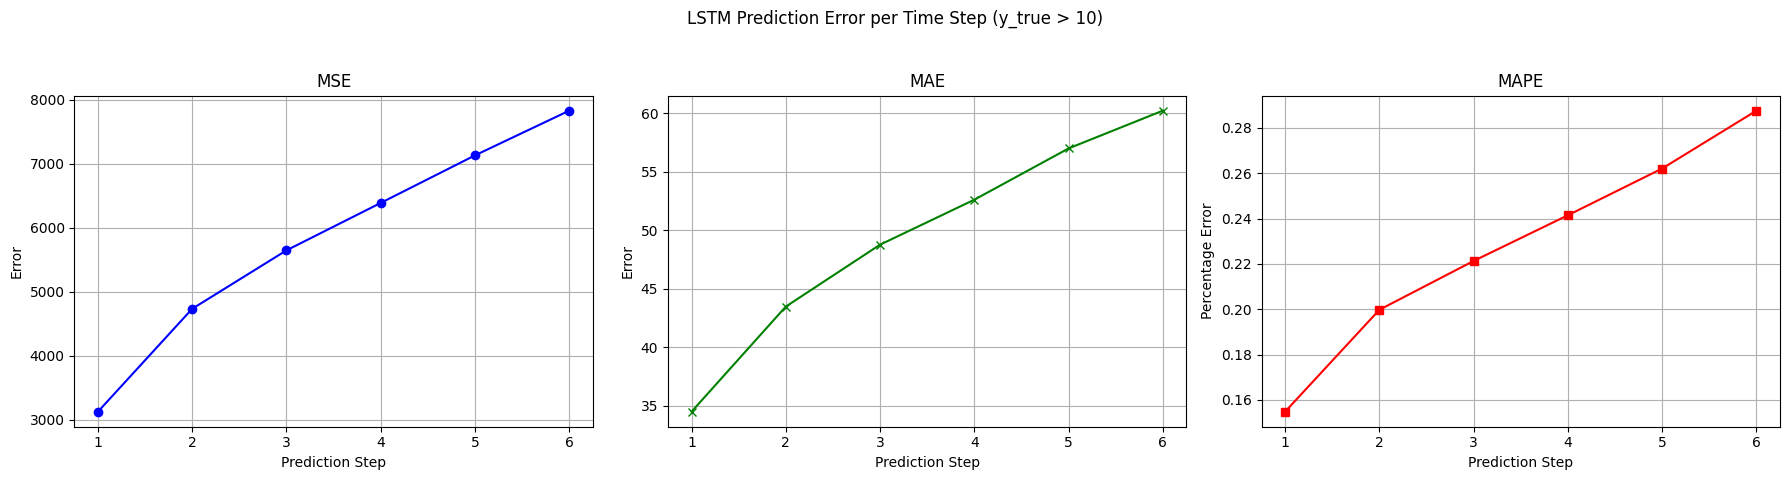

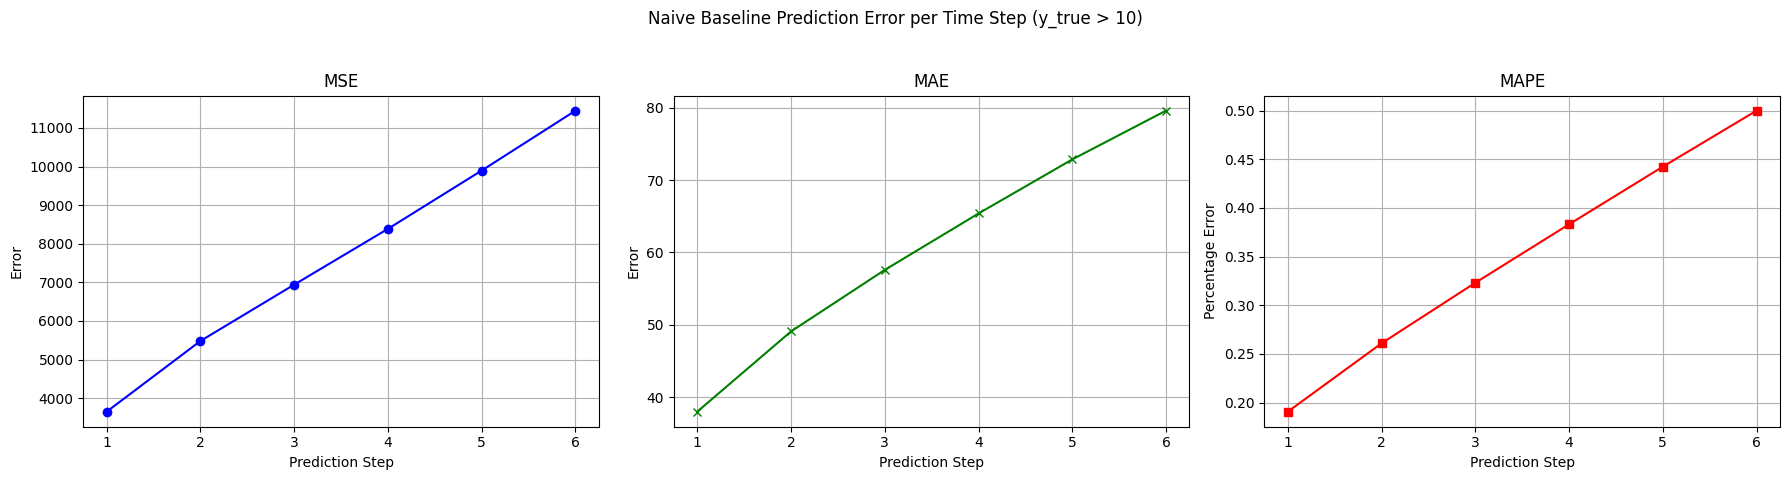

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# 定义函数来计算多步预测指标，包括 MAPE，只统计对应实际值大于 10 的数据
def evaluate_filtered_multi_step_predictions(y_true, y_pred, threshold=10):
    num_steps = y_true.shape[1]
    mse_per_step = []
    mae_per_step = []
    mape_per_step = []

    for step in range(num_steps):
        # 过滤实际值大于 10 的位置
        valid_indices = y_true[:, step] > threshold
        y_true_filtered = y_true[valid_indices, step]
        y_pred_filtered = y_pred[valid_indices, step]

        if len(y_true_filtered) > 0:  # 确保有可用数据进行计算
            mse = mean_squared_error(y_true_filtered, y_pred_filtered)
            mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
            mape = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered)
            mse_per_step.append(mse)
            mae_per_step.append(mae)
            mape_per_step.append(mape)

    # 汇总平均指标
    avg_mse = np.mean(mse_per_step)
    avg_mae = np.mean(mae_per_step)
    avg_mape = np.mean(mape_per_step)
    avg_rmse = np.sqrt(avg_mse)

    print(f'Average MSE over {num_steps} steps (y_true > {threshold}): {avg_mse:.4f}')
    print(f'Average RMSE over {num_steps} steps (y_true > {threshold}): {avg_rmse:.4f}')
    print(f'Average MAE over {num_steps} steps (y_true > {threshold}): {avg_mae:.4f}')
    print(f'Average MAPE over {num_steps} steps (y_true > {threshold}): {avg_mape:.4%}')

    return mse_per_step, mae_per_step, mape_per_step

# # 实现持平模型的预测（后移 1/2 output_size）
# def naive_baseline_forecast(y_true, shift=3):
#     # 按 shift 大小后移数据，填充后面的步长为 NaN
#     y_pred_naive = np.roll(y_true, shift=shift, axis=0)
#     y_pred_naive[:shift, :] = np.nan
#     return y_pred_naive

# # 使用持平模型进行预测（这里 shift 是 output_size 的一半）
# y_pred_naive = naive_baseline_forecast(y_test_multi_inverse)
# # 去掉 NaN 行以进行对比评估
# valid_indices = ~np.isnan(y_pred_naive).any(axis=1)
# y_test_multi_valid = y_test_multi_inverse[valid_indices]
# y_pred_naive_valid = y_pred_naive[valid_indices]
def mean_baseline_forecast(y_true, window_size, output_size):
    """
    使用过去 window_size 个时间步的平均值来预测未来 output_size 个时间步。
    参数:
    - y_true: 实际值 (形状: [样本数, 时间步数])
    - window_size: 用于计算平均值的历史窗口大小
    - output_size: 未来预测的时间步长
    返回:
    - y_pred_naive: 平均后移预测值
    """
    y_pred_naive = np.zeros_like(y_true)
    for i in range(window_size, len(y_true) - output_size):
        mean_value = np.mean(y_true[i - window_size:i, 0])  # 计算过去 window_size 个时间步的平均值
        y_pred_naive[i, :] = mean_value  # 用平均值填充未来的 output_size 步预测
    
    # 将初始 window_size 行和尾部无法预测的行填充为 NaN
    y_pred_naive[:window_size, :] = np.nan
    y_pred_naive[-output_size:, :] = np.nan
    
    return y_pred_naive

# 使用平均后移模型进行预测）
window_size = output_size // 2  # 取 output_size 的一半作为历史窗口大小
y_pred_naive = mean_baseline_forecast(y_test_multi_inverse, window_size, output_size)

# 去掉 NaN 行以进行对比评估
valid_indices = ~np.isnan(y_pred_naive).any(axis=1)
y_test_multi_valid = y_test_multi_inverse[valid_indices]
y_pred_naive_valid = y_pred_naive[valid_indices]


# 评价持平模型（只统计实际值大于 10 的数据）
mse_per_step_naive, mae_per_step_naive, mape_per_step_naive = evaluate_filtered_multi_step_predictions(
    y_test_multi_valid, y_pred_naive_valid, threshold=10
)

# 评价 LSTM 模型（只统计实际值大于 10 的数据）
mse_per_step_lstm, mae_per_step_lstm, mape_per_step_lstm = evaluate_filtered_multi_step_predictions(
    y_test_multi_inverse, y_pred_lstm, threshold=10
)


# 修改后的可视化函数，使用小图来展示每个模型的误差
def plot_error_metrics_subplots(mse_per_step, mae_per_step, mape_per_step, model_name="Model"):
    steps = range(1, len(mse_per_step) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{model_name} Prediction Error per Time Step (y_true > 10)')

    # 绘制 MSE
    axes[0].plot(steps, mse_per_step, marker='o', color='b', label='MSE')
    axes[0].set_title('MSE')
    axes[0].set_xlabel('Prediction Step')
    axes[0].set_ylabel('Error')
    axes[0].grid(True)

    # 绘制 MAE
    axes[1].plot(steps, mae_per_step, marker='x', color='g', label='MAE')
    axes[1].set_title('MAE')
    axes[1].set_xlabel('Prediction Step')
    axes[1].set_ylabel('Error')
    axes[1].grid(True)

    # 绘制 MAPE
    axes[2].plot(steps, mape_per_step, marker='s', color='r', label='MAPE')
    axes[2].set_title('MAPE')
    axes[2].set_xlabel('Prediction Step')
    axes[2].set_ylabel('Percentage Error')
    axes[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 绘制 LSTM 模型的误差指标
plot_error_metrics_subplots(mse_per_step_lstm, mae_per_step_lstm, mape_per_step_lstm, model_name="LSTM")


# 绘制持平模型的误差指标
plot_error_metrics_subplots(mse_per_step_naive, mae_per_step_naive, mape_per_step_naive, model_name="Naive Baseline")
